In [1]:
!pip install opendatasets

In [46]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import f1_score,roc_curve,accuracy_score,confusion_matrix,classification_report,roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
import joblib




In [5]:
od.download("https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahmoud
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction


100%|██████████| 8.56k/8.56k [00:00<00:00, 21.2MB/s]

In [7]:
df = pd.read_csv("/content/heart-failure-prediction/heart.csv")

In [8]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [9]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [10]:
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


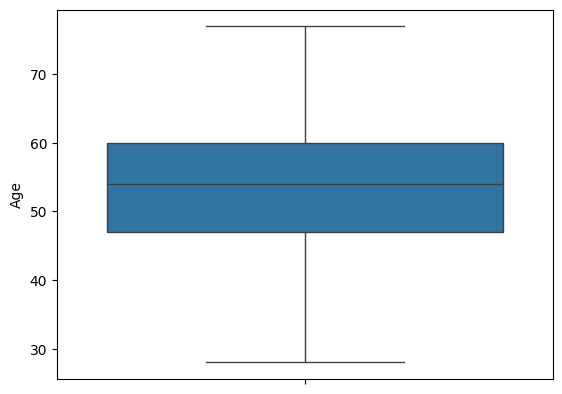

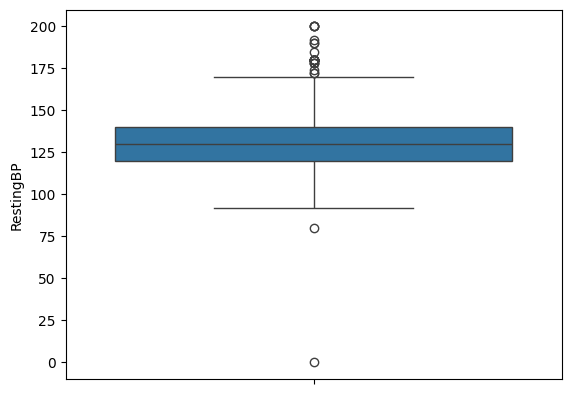

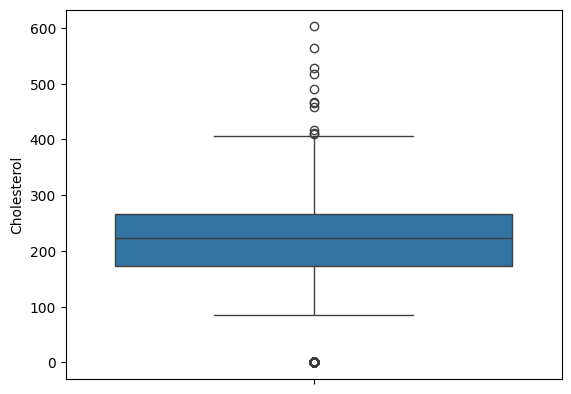

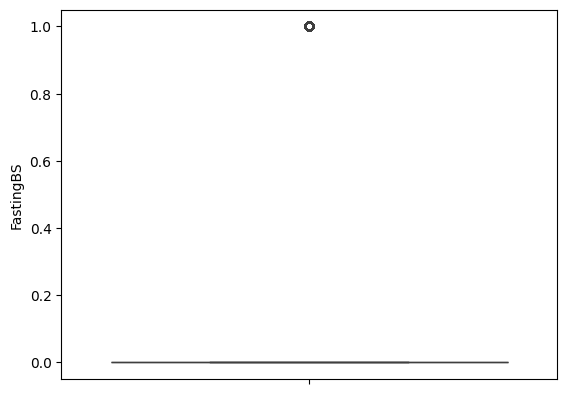

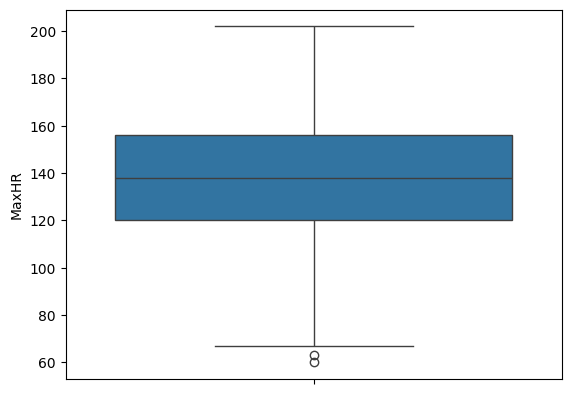

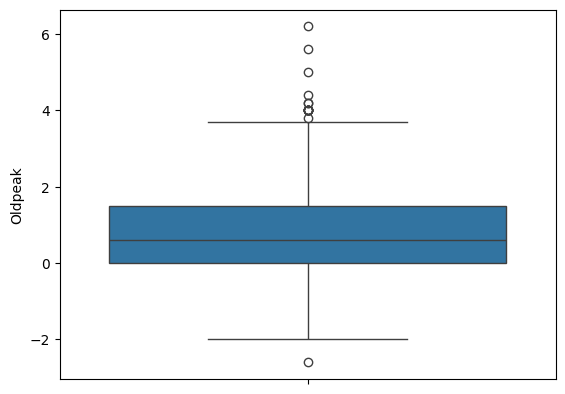

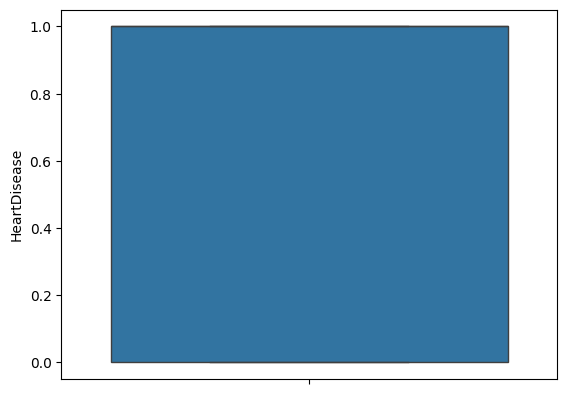

In [12]:
numerical_columns = df.select_dtypes(include=['int64', 'float64','int32']).columns
for column in numerical_columns:
  sns.boxplot(df[column])
  plt.show()


In [13]:
def remove_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df

In [14]:
df = remove_outliers(df, 'RestingBP')
df = remove_outliers(df, 'Cholesterol')
df = remove_outliers(df, 'Oldpeak')

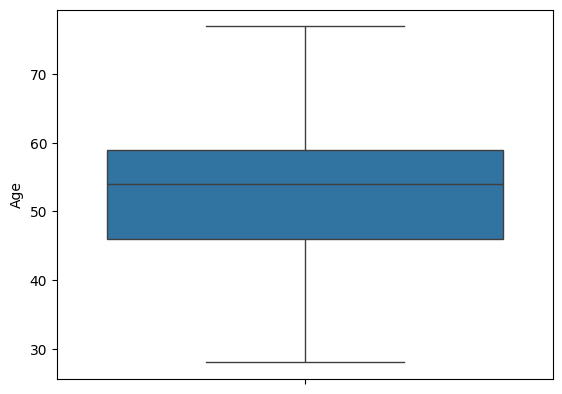

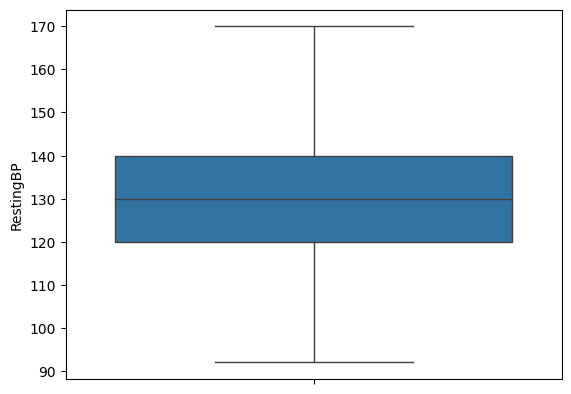

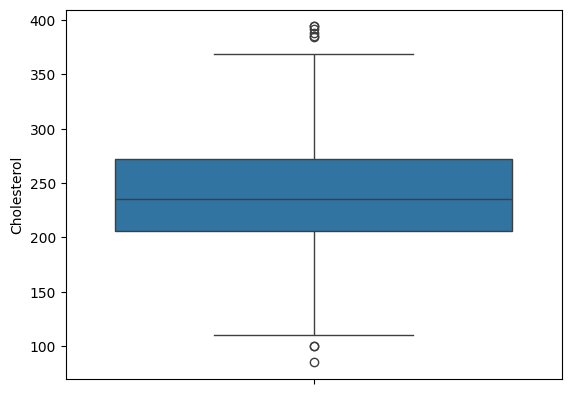

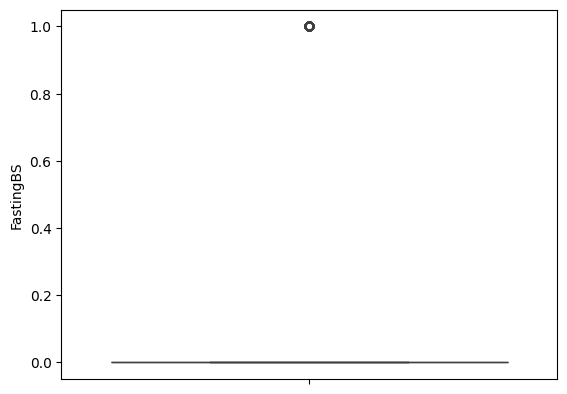

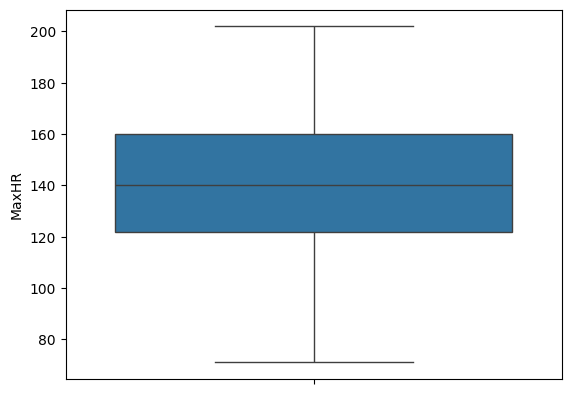

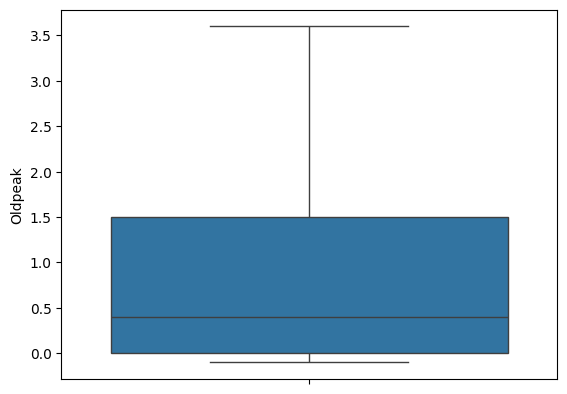

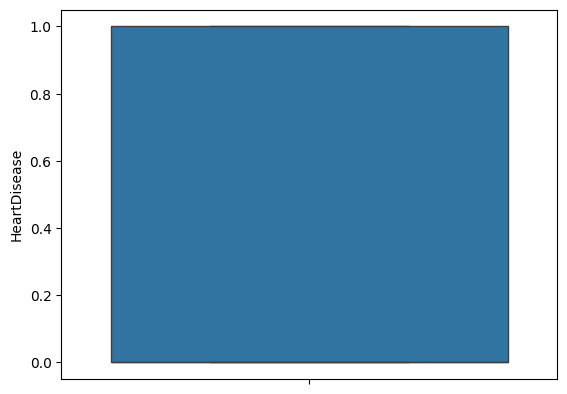

In [15]:
for column in numerical_columns:
  sns.boxplot(df[column])
  plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 701 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             701 non-null    int64  
 1   Sex             701 non-null    object 
 2   ChestPainType   701 non-null    object 
 3   RestingBP       701 non-null    int64  
 4   Cholesterol     701 non-null    int64  
 5   FastingBS       701 non-null    int64  
 6   RestingECG      701 non-null    object 
 7   MaxHR           701 non-null    int64  
 8   ExerciseAngina  701 non-null    object 
 9   Oldpeak         701 non-null    float64
 10  ST_Slope        701 non-null    object 
 11  HeartDisease    701 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 71.2+ KB


In [19]:
LE = LabelEncoder()
df['Sex'] = LE.fit_transform(df['Sex'])
df['ChestPainType'] = LE.fit_transform(df['ChestPainType'])
df['RestingECG'] = LE.fit_transform(df['RestingECG'])
df['ExerciseAngina'] = LE.fit_transform(df['ExerciseAngina'])
df['ST_Slope'] = LE.fit_transform(df['ST_Slope'])

In [48]:
# ss = StandardScaler()
# df['Age'] = ss.fit_transform(df[['Age']])
# df['RestingBP'] = ss.fit_transform(df[['RestingBP']])
# df['Cholesterol'] = ss.fit_transform(df[['Cholesterol']])
# df['MaxHR'] = ss.fit_transform(df[['MaxHR']])
# df['Oldpeak'] = ss.fit_transform(df[['Oldpeak']])

scaler = StandardScaler()
df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']] = scaler.fit_transform(
    df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [49]:
x = df.drop('HeartDisease',axis=1)
y = df['HeartDisease']
y.value_counts()

,count
HeartDisease,
0,377
1,324


In [50]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [51]:
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test),callbacks=[ES])

Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6885 - loss: 0.6297 - val_accuracy: 0.8298 - val_loss: 0.4883
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8258 - loss: 0.4928 - val_accuracy: 0.8298 - val_loss: 0.4023
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8077 - loss: 0.4488 - val_accuracy: 0.8298 - val_loss: 0.3589
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8455 - loss: 0.4078 - val_accuracy: 0.8582 - val_loss: 0.3483
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8160 - loss: 0.4127 - val_accuracy: 0.8582 - val_loss: 0.3404
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8465 - loss: 0.3755 - val_accuracy: 0.8511 - val_loss: 0.3295
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8508 - loss: 0.3686 - val_accuracy: 0.8511 - val_loss: 0.3220
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8576 - loss: 0.3478 - val_accuracy: 0.8582 - 

In [52]:
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32")
f1_score(y_test,y_pred_classes)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


0.9066666666666666

In [53]:
roc_auc_score(y_test,y_pred)

np.float64(0.9534086325131101)

In [54]:
roc_curve(y_test,y_pred)

(array([0.        , 0.        , 0.        , 0.01492537, 0.01492537,
        0.02985075, 0.02985075, 0.04477612, 0.04477612, 0.05970149,
        0.05970149, 0.07462687, 0.07462687, 0.10447761, 0.10447761,
        0.17910448, 0.17910448, 0.25373134, 0.25373134, 0.31343284,
        0.31343284, 0.52238806, 0.52238806, 1.        ]),
 array([0.        , 0.01351351, 0.56756757, 0.56756757, 0.59459459,
        0.59459459, 0.60810811, 0.60810811, 0.64864865, 0.64864865,
        0.67567568, 0.67567568, 0.87837838, 0.87837838, 0.91891892,
        0.91891892, 0.94594595, 0.94594595, 0.97297297, 0.97297297,
        0.98648649, 0.98648649, 1.        , 1.        ]),
 array([       inf, 0.99747163, 0.88653255, 0.8818485 , 0.8683873 ,
        0.8601834 , 0.84658206, 0.84544444, 0.8301625 , 0.80792767,
        0.7820932 , 0.7703464 , 0.64641404, 0.57953864, 0.5132127 ,
        0.3986507 , 0.37069213, 0.24131061, 0.19217269, 0.18686293,
        0.17660406, 0.06661218, 0.06495281, 0.00277707], dtype=float

In [55]:
classification_report(y_test,y_pred_classes)


'              precision    recall  f1-score   support\n\n           0       0.91      0.88      0.89        67\n           1       0.89      0.92      0.91        74\n\n    accuracy                           0.90       141\n   macro avg       0.90      0.90      0.90       141\nweighted avg       0.90      0.90      0.90       141\n'

In [56]:
model.save("heart_failure_model.keras")


In [57]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

['scaler.pkl']